In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA

In [2]:
df = pd.read_csv('FedYieldCurve.csv', index_col = 'Unnamed: 0')
df

,R_3M,R_6M,R_1Y,R_2Y,R_3Y,R_5Y,R_7Y,R_10Y
1981-12-31,12.92,13.90,14.32,14.57,14.64,14.65,14.67,14.59
1982-01-31,14.28,14.81,14.73,14.82,14.73,14.54,14.46,14.43
1982-02-28,13.31,13.83,13.95,14.19,14.13,13.98,13.93,13.86
1982-03-31,13.34,13.87,13.98,14.20,14.18,14.00,13.94,13.87
1982-04-30,12.71,13.13,13.34,13.78,13.77,13.75,13.74,13.62
...,...,...,...,...,...,...,...,...
2012-07-31,0.10,0.14,0.18,0.27,0.37,0.71,1.14,1.68
2012-08-31,0.11,0.14,0.18,0.26,0.34,0.67,1.12,1.72
2012-09-30,0.10,0.15,0.18,0.28,0.37,0.71,1.15,1.75
2012-10-31,0.09,0.14,0.18,0.27,0.36,0.67,1.08,1.65


In [3]:
M = (df.to_numpy()-df.mean().values)/df.std().values
pca = PCA(n_components=3).fit_transform(M)
pca

array([[ 8.11896669e+00, -3.36699780e-02, -2.58450685e-02],
       [ 8.40610496e+00,  4.12873617e-01, -2.13726479e-01],
       [ 7.75721621e+00,  2.83637324e-01, -1.28682042e-01],
       ...,
       [-4.55862034e+00,  2.50518545e-01,  5.46911722e-03],
       [-4.58873504e+00,  2.79431560e-01,  2.18336972e-02],
       [-4.57953612e+00,  2.49087599e-01,  1.04525224e-02]])

In [4]:
yield_curve = pd.DataFrame(data = pca, index = df.index, columns=['level','slope' ,'curvature'])

In [5]:
yield_curve

,level,slope,curvature
1981-12-31,8.118967,-0.033670,-0.025845
1982-01-31,8.406105,0.412874,-0.213726
1982-02-28,7.757216,0.283637,-0.128682
1982-03-31,7.780115,0.290709,-0.126933
1982-04-30,7.374156,0.128420,-0.102887
...,...,...,...
2012-07-31,-4.570811,0.263368,0.015392
2012-08-31,-4.576198,0.264196,0.001650
2012-09-30,-4.558620,0.250519,0.005469
2012-10-31,-4.588735,0.279432,0.021834


In [6]:
yield_curve.columns[i]

NameError: name 'i' is not defined

<AxesSubplot: title={'center': 'Level'}>

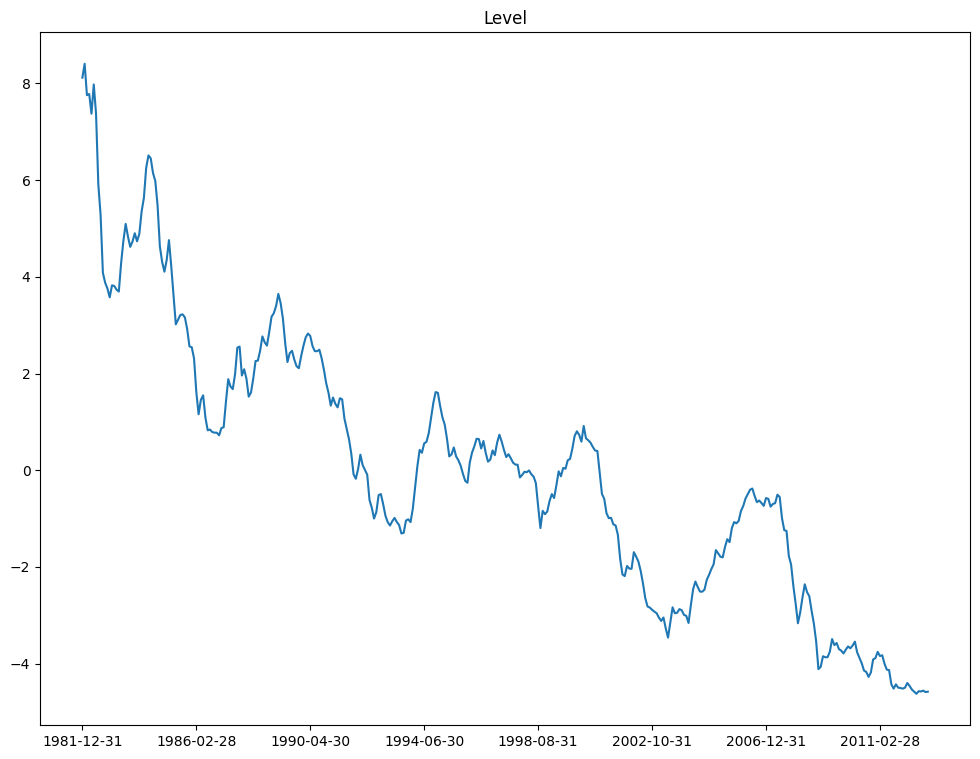

In [9]:
fig, ax = plt.subplots(figsize = (12,9))
plt.title('Level')
yield_curve.level.plot()

In [ ]:
H = np.vstack((np.ones(yield_curve.shape[0]),np.exp(np.arange(0,yield_curve.shape[0]))))
H

(2, 372)

# Nelson - Siegel Model

In [27]:
import numpy as np

M = np.array([[2.0,3.0],
              [1.0, 2.5],
              [3.5,1.5]])
eig_U, eig_vec_U = np.linalg.eig(M.dot(M.T)) 
eig_V, eig_vec_V = np.linalg.eig(M.T.dot(M))


In [40]:
Sigma = eig_vec_U.T.dot(M.dot(eig_vec_V))

In [48]:
M.dot(eig_vec_V)

array([[ 0.69102937, -3.53871141],
       [ 1.04940014, -2.4796692 ],
       [-1.43026906, -3.52906934]])

In [47]:
M.dot(eig_vec_V[:,0])

array([ 0.69102937,  1.04940014, -1.43026906])